<a href="https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/nvt_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Temperature Simulation

Here we demonstrate some code to run a simulation at in the NVT ensemble. We start off by setting up some parameters of the simulation. This will include a temperature schedule that will start off at a high temperature and then instantaneously quench to a lower temperature.

In [2]:
N = 400
dimension = 2
box_size = quantity.box_size_at_number_density(N, 0.8, 2)
dt = 5e-3
displacement, shift = space.periodic(box_size) 

kT = lambda t: np.where(t < 5000.0 * dt, 0.1, 0.01)

Next we need to generate some random positions as well as particle sizes.

In [3]:
key = random.PRNGKey(0)

In [4]:
key, split = random.split(key)
R = box_size * random.uniform(split, (N, dimension), dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [5]:
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT(0.))
state = init(key, R)

Now let's actually do the simulation. To do this we'll write a small function that performs a single step of the simulation. This function will keep track of the temperature, the extended Hamiltonian of the Nose-Hoover dynamics, and the current particle positions.

In [6]:
write_every = 100

def step_fn(i, state_and_log):
  state, log = state_and_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(state.velocity)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT(t))
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT(t))
  
  return state, log

To run our simulation we'll use `lax.fori_loop` which will execute the simulation a single call from python.

In [7]:
steps = 10000

log = {
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

R = state.position

Now, let's plot the temperature as a function of time. We see that the temperature tracks the goal temperature with some fluctuations.

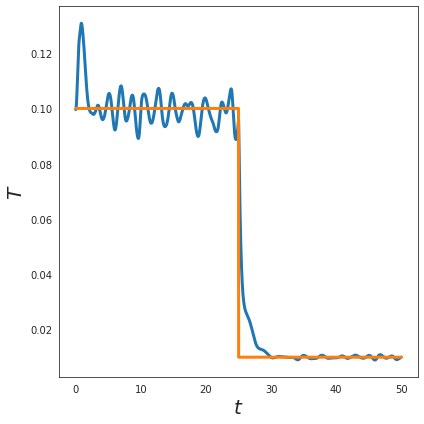

In [8]:
t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT(t), linewidth=3)
format_plot('$t$', '$T$')
finalize_plot()

Now let's plot the Hamiltonian of the system. We see that it is invariant apart from changes to the temperature, as expected.

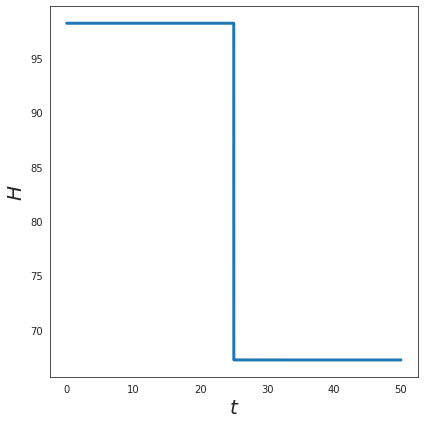

In [9]:
plt.plot(t, log['H'], linewidth=3)
format_plot('$t$', '$H$')
finalize_plot()

Now let's plot a snapshot of the system.

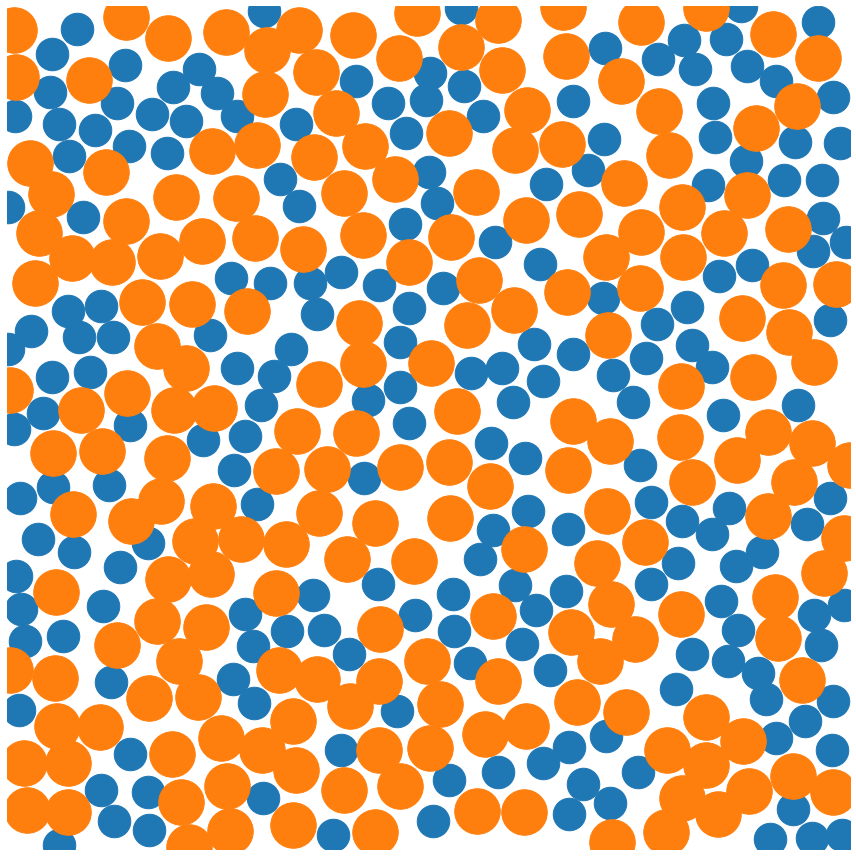

In [10]:
ms = 65
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

If we want, we can also draw an animation of the simulation using JAX MD's renderer.

In [ ]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]
colors = np.where(species[:, None], 
                  np.array([[1.0, 0.5, 0.01]]), 
                  np.array([[0.35, 0.65, 0.85]]))

renderer.render(box_size,
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                resolution=(700, 700))

## Larger Simulation with Neighbor Lists

We can use neighbor lists to run a much larger version of this simulation. As their name suggests, neighbor lists are lists of particles nearby a central particle. By keeping track of neighbors, we can compute the energy of the system much more efficiently. This becomes increasingly true as the simulation gets larger. 

In [12]:
N = 128000
box_size = quantity.box_size_at_number_density(N, 0.8, 2)
displacement, shift = space.periodic(box_size) 

kT = lambda t: np.where(t < 50.0, 0.1, 0.01)

As before we randomly initialize the system.

In [13]:
key, split = random.split(key)
R = box_size * random.uniform(split, (N, dimension), dtype=np.float64)

sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators. This time we use the `energy.soft_sphere_neighbor_fn` to create two functions: one that constructs lists of neighbors and one that computes the energy.

In [14]:
neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(displacement,
                                                          box_size,
                                                          species=species, 
                                                          sigma=sigma)

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT(0.), tau=200*dt)

nbrs = neighbor_fn.allocate(R)
state = init(key, R, neighbor=nbrs)

Now let's actually do the simulation. This time our simulation step function will also update the neighbors. As above, we will also only record position data every hundred steps.

In [15]:
write_every = 100

def step_fn(i, state_nbrs_log):
  state, nbrs, log = state_nbrs_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(state.velocity)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT(t), neighbor=nbrs)
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT(t), neighbor=nbrs)
  nbrs = nbrs.update(state.position)

  return state, nbrs, log

To run our simulation we'll use `lax.fori_loop` which will execute the simulation a single call from python.

In [16]:
steps = 20000

log = {
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, nbrs, log = lax.fori_loop(0, steps, step_fn, (state, nbrs, log))

R = state.position

Now, let's plot the temperature as a function of time. We see that the temperature tracks the goal temperature with some fluctuations.

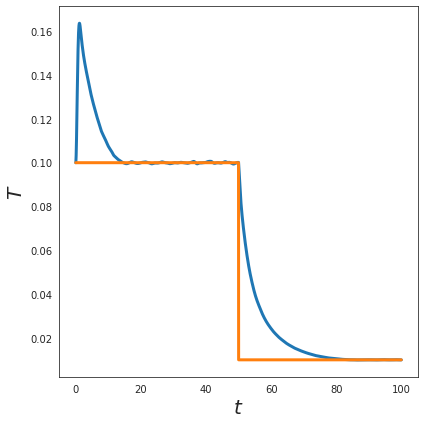

In [17]:
t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT(t), linewidth=3)
format_plot('$t$', '$T$')
finalize_plot()

Now let's plot the Hamiltonian of the system. We see that it is invariant apart from changes to the temperature, as expected.

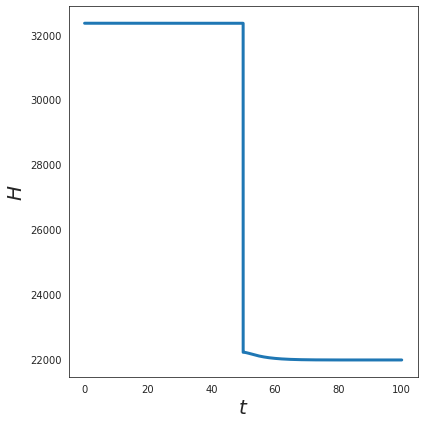

In [18]:
plt.plot(t, log['H'], linewidth=3)
format_plot('$t$', '$H$')
finalize_plot()

Now let's plot a snapshot of the system.

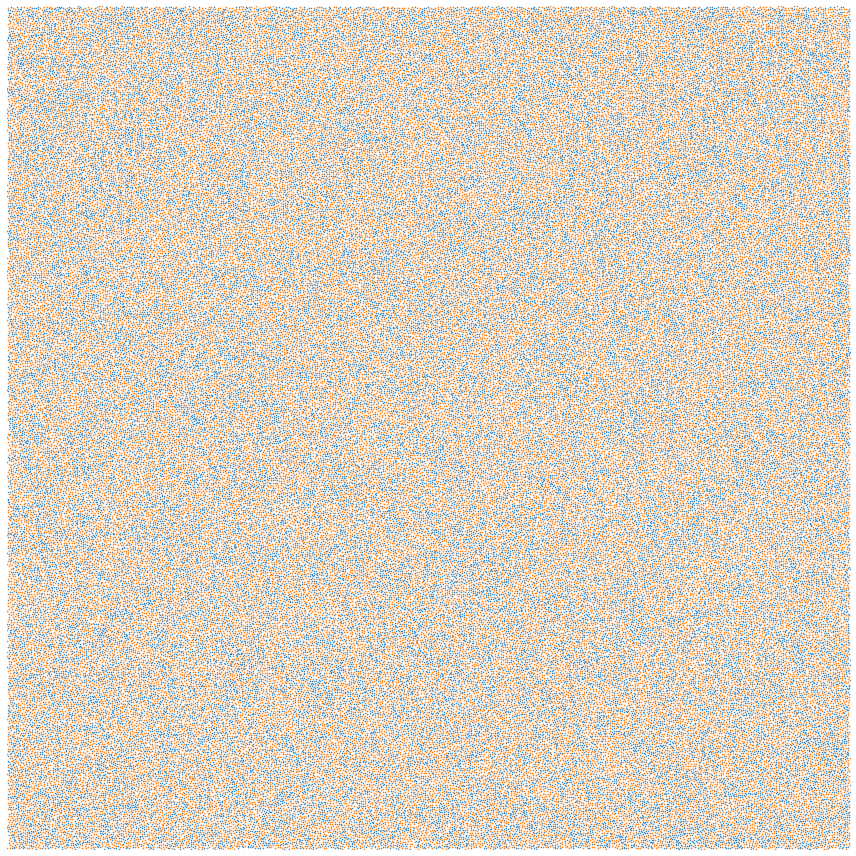

In [19]:
ms = 1
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Finally, let's plot the velocity distribution compared with its theoretical prediction.

In [20]:
V_flat = onp.reshape(onp.array(state.velocity), (-1,))
occ, bins = onp.histogram(V_flat, bins=100, normed=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


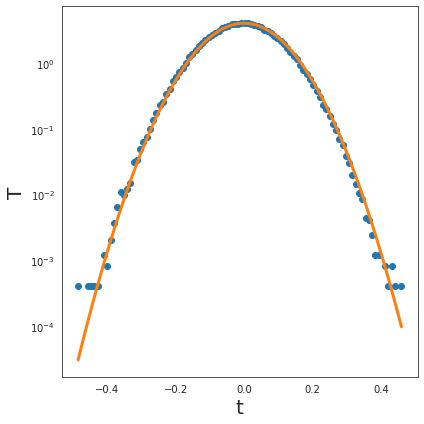

In [21]:
T_cur = kT(steps * dt)
plt.semilogy(bins[:-1], occ, 'o')
plt.semilogy(
    bins[:-1], 
    1.0 / np.sqrt(2 * np.pi * T_cur) * onp.exp(-1/(2 * T_cur) * bins[:-1] ** 2), 
    linewidth=3)
format_plot('t', 'T')
finalize_plot()